## ARIMA Project for estimating future quarterly EPS

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [48]:
plt.rcParams['figure.figsize']=[10,7.5]

### importing data

In [49]:
data = pd.read_csv('jj.csv')

In [50]:
data.head()


,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


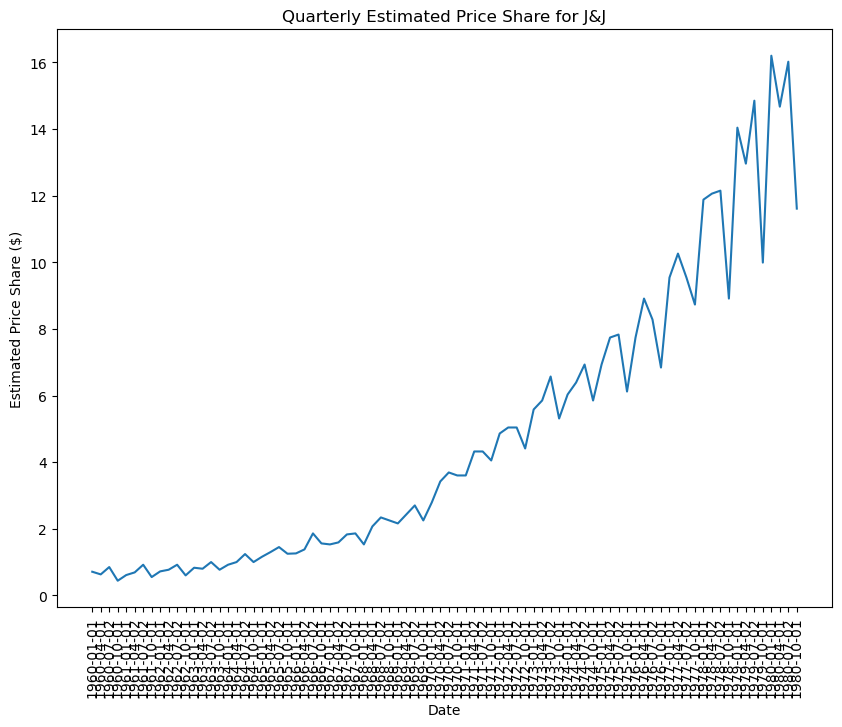

In [7]:
plt.plot(data['date'],data['data'])
plt.title("Quarterly Estimated Price Share for J&J")
plt.ylabel("Estimated Price Share ($)")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.show()

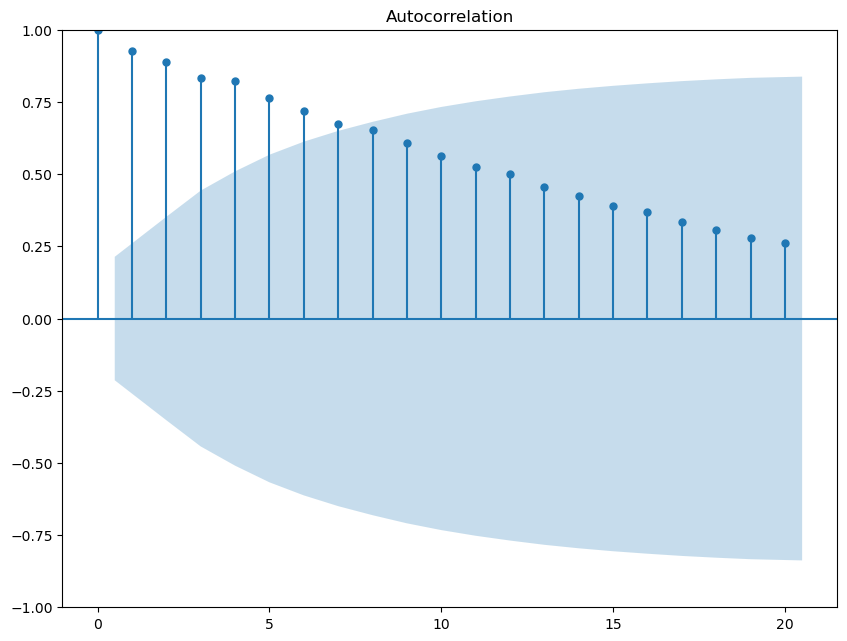

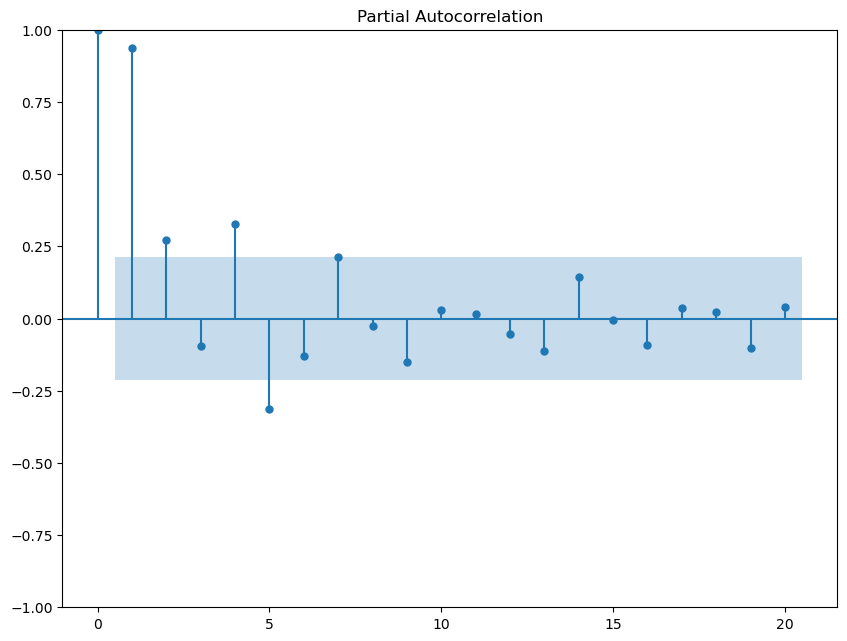

In [8]:
plot_acf(data['data']);
plot_pacf(data['data']);

## Making it stationary

In [10]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()
data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


Text(0.5, 1.0, 'log difference of EPS Quarterly for J&J')

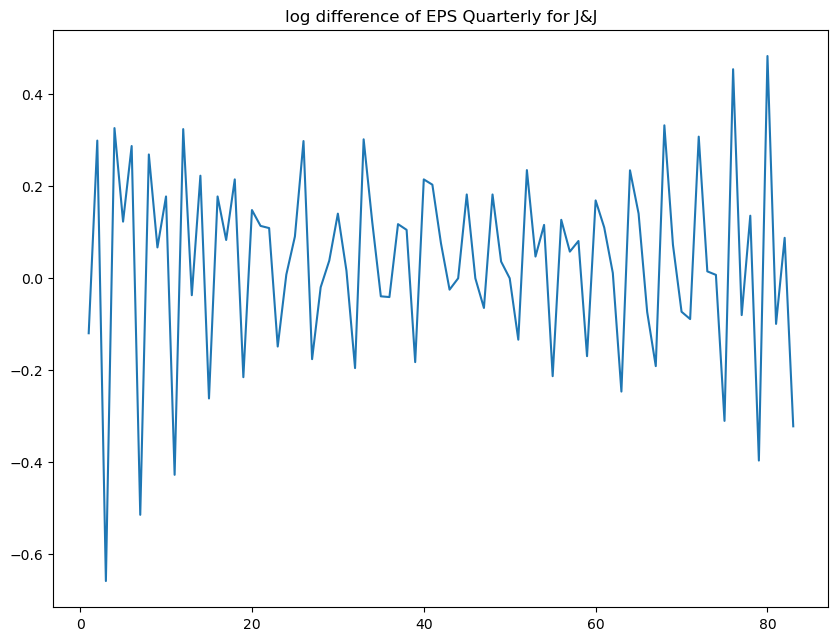

In [11]:
plt.plot(data['data_tr_1'])
plt.title('log difference of EPS Quarterly for J&J')

### checking for stationarity

In [13]:
ad_fuller_result = adfuller(data['data_tr_1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}' )
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811826
p-value: 0.0004149731404440838


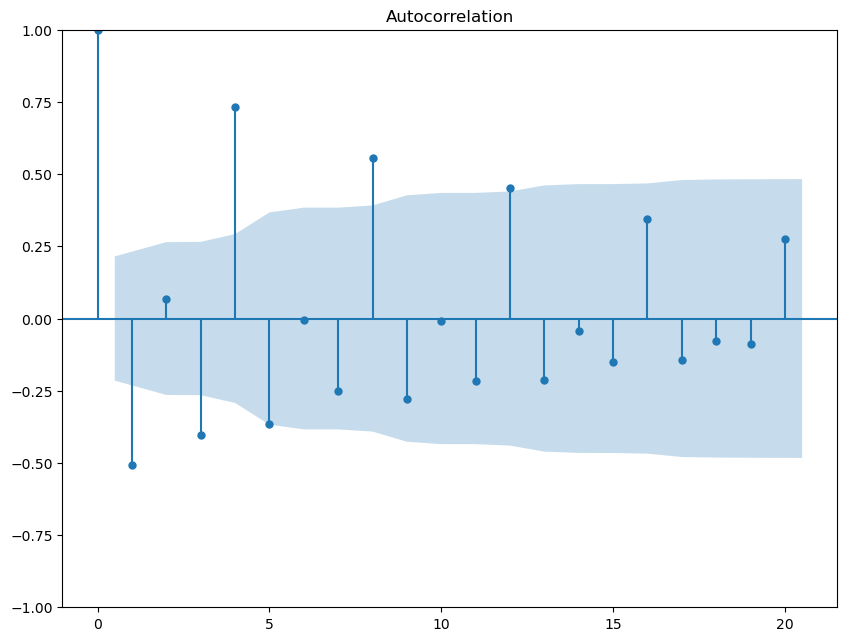

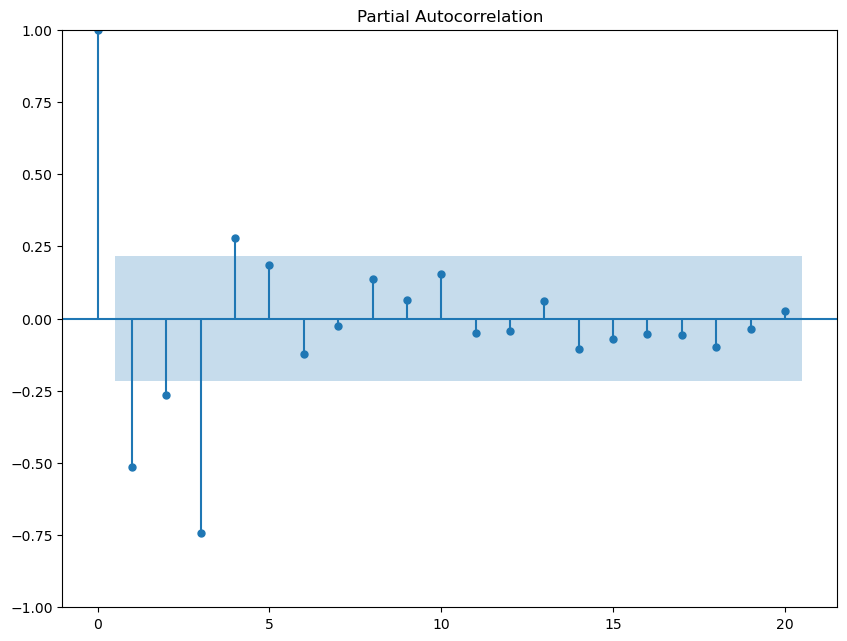

In [14]:
plot_acf(data['data_tr_1'][1:]);
plot_pacf(data['data_tr_1'][1:]);


In [39]:
def optimize_ARIMA(endog, order_list):
    """
    Returns a dataframe with parameters and corresponding AIC
    
    order_list =  list with (p,d,q) tuples
    endog = observed variable
    
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order = order, simple_differencing = False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)' , 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending= True).reset_index(drop = True)
    
    return result_df

In [40]:
ps = range(0,8,1)
d=1
qs = range(0,8,1)

parameters = product(ps,qs)
parameters_list = list(parameters)


order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1,1)
    each = tuple(each)
    order_list.append(each)
    
    
order_list[:10]   

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (1, 1, 0),
 (1, 1, 1)]

In [41]:
result_df = optimize_ARIMA(data['data'], order_list)
result_df

  0%|          | 0/64 [00:00<?, ?it/s]

,"(p,d,q)",AIC
0,"(6, 1, 3)",115.336139
1,"(4, 1, 6)",115.859357
2,"(7, 1, 1)",116.052954
3,"(5, 1, 3)",116.534552
4,"(5, 1, 4)",117.244323
...,...,...
59,"(0, 1, 1)",265.481216
60,"(0, 1, 3)",265.497398
61,"(1, 1, 0)",266.632563
62,"(2, 1, 0)",267.751437


In [42]:
best_model = SARIMAX(data['data'], order=(6,1,3), simple_differencing = False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:               SARIMAX(6, 1, 3)   Log Likelihood                 -47.668
Date:                Sat, 25 Nov 2023   AIC                            115.336
Time:                        18:50:32   BIC                            139.525
Sample:                             0   HQIC                           125.054
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4654      0.122    -11.985      0.000      -1.705      -1.226
ar.L2         -0.7563      0.145     -5.220      0.000      -1.040      -0.472
ar.L3          0.0422      0.062      0.684      0.4

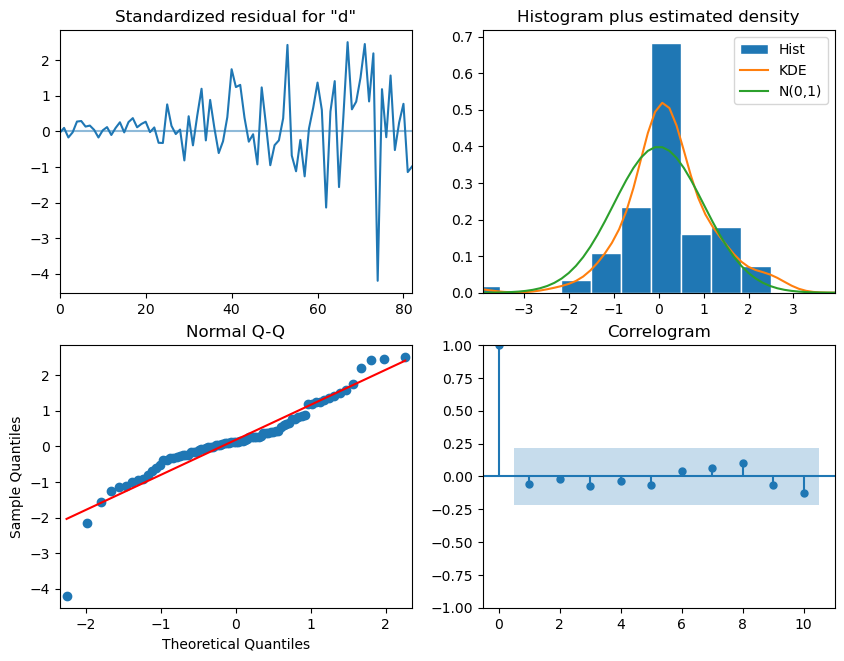

In [43]:
res.plot_diagnostics();

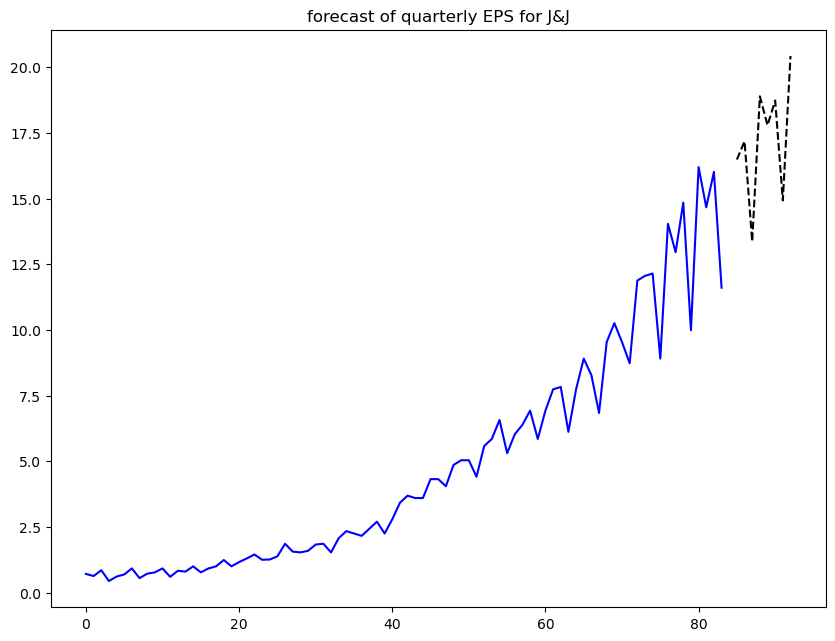

In [44]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))


fig, ax = plt.subplots()
ax.plot(data['data'],'blue')
ax.plot(idx[-n_forecast:],predict.predicted_mean[-n_forecast:], 'k--')


ax.set(title="forecast of quarterly EPS for J&J" )
plt.show()

In [45]:
data['model']=predict.predicted_mean
data.head()

,date,data,data_tr_1,model
0,1960-01-01,0.71,NaN,0.000000
1,1960-04-01,0.63,-0.119545,0.709998
2,1960-07-02,0.85,0.299517,0.679182
3,1960-10-01,0.44,-0.658462,0.723500
4,1961-01-01,0.61,0.326684,0.647324


In [46]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE:{mse}')

MSE:0.16022814152737905
